In [1]:
import pandas as pd
import os 
import glob
import numpy as np
from scipy.stats import skew, kurtosis
from scipy.fft import fft
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
import joblib
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb


print("done")


done


In [2]:
def create_windows(data, sample_rate):
    start_time = data['timestamp'].iloc[0]
    end_time = data['timestamp'].iloc[-1]
    
    intervals = pd.date_range(start=start_time, end=end_time, freq = '1s')
    
    windows = []
    labels = []
    
    for i in range(len(intervals) - 1):
        start = intervals[i]
        end = intervals[i+1]
        
        window_data = data[(data['timestamp'] >= start) & (data['timestamp'] < end)]
        
        if len(window_data) >= sample_rate:
            windows.append(window_data[['thigh_x', 'thigh_y', 'thigh_z']].values)
            
            labels.append(window_data['label'].mode()[0])
            
    return windows, labels
print("Done") 

Done


In [3]:
def extract_features(windows):
    features = []

    for i, window in enumerate(windows):

        feature_dict = {}
        x, y, z = window[:, 0], window[:, 1], window[:, 2]

        # Basic Features
        feature_dict['X_mean'] = np.mean(x)
        feature_dict['Y_mean'] = np.mean(y)
        feature_dict['Z_mean'] = np.mean(z)

        feature_dict['X_stdev'] = np.std(x)
        feature_dict['Y_stdev'] = np.std(y)
        feature_dict['Z_stdev'] = np.std(z)

        feature_dict['X_range'] = np.max(x) - np.min(x)
        feature_dict['Y_range'] = np.max(y) - np.min(y)
        feature_dict['Z_range'] = np.max(z) - np.min(z)

        # Correlation Features (with safety checks)
        feature_dict['Corr_xy'] = safe_corrcoef(x, y)
        feature_dict['Corr_yz'] = safe_corrcoef(y, z)
        feature_dict['Corr_xz'] = safe_corrcoef(x, z)

        # Vector Magnitude
        vector_magnitude = np.sqrt(x**2 + y**2 + z**2)
        feature_dict['||e||2_mean'] = np.mean(vector_magnitude)
        feature_dict['||e||2_range'] = np.max(vector_magnitude) - np.min(vector_magnitude)
        feature_dict['||e||2_median'] = np.median(vector_magnitude)
        feature_dict['||e||2_skew'] = skew(vector_magnitude)
        feature_dict['||e||2_stdev'] = np.std(vector_magnitude)
        feature_dict['||e||2_absdev'] = np.mean(np.abs(vector_magnitude - np.mean(vector_magnitude)))

        # Kurtosis
        feature_dict['kurtosis'] = kurtosis(vector_magnitude)

        # Power Spectral Features
        fft_vals = np.abs(fft(vector_magnitude))
        feature_dict['Pow1'] = np.sum(fft_vals[:len(fft_vals)//4])
        feature_dict['Pow2'] = np.sum(fft_vals[len(fft_vals)//4:len(fft_vals)//2])

        features.append(feature_dict)

    features_df = pd.DataFrame(features)

    features_df.fillna(0, inplace=True)
    features_df.replace([np.inf, -np.inf], 0, inplace=True)

    return features_df


# Safe correlation calculation
def safe_corrcoef(a, b):
    if len(a) < 2 or np.std(a) == 0 or np.std(b) == 0:
        return np.nan  # or 0
    return np.corrcoef(a, b)[0, 1]
print("Complete")

Complete


In [4]:
folder_path = 'thigh_dataset/harth/training_data'

csv_files = glob.glob(os.path.join(folder_path, "*.csv"))

sample_rate = 50
all_features = []
all_labels = []

# Define label mapping at the top of your code
label_mapping = {
    1: 0, 2: 1, 3: 2, 4: 3, 5: 4, 6: 5, 7: 6, 8: 7, 13: 8, 14: 9, 130: 10, 140: 11
}

# In your data loading and window creation step
for file in csv_files:
    df = pd.read_csv(file)
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    data = df.sort_values(by='timestamp')
    
    # Apply the label mapping to convert labels to continuous integers
    df['label'] = df['label'].map(label_mapping)
    
    thigh_data = data[['timestamp', 'thigh_x', 'thigh_y', 'thigh_z', 'label']]
    windows, labels = create_windows(thigh_data, sample_rate)

    print(f"No. of 1-s windows created: {len(windows)}")
    if len(windows) > 0:
        features_df = extract_features(windows)
        all_features.append(features_df)
        all_labels.extend(labels)

print("Feature extraction complete.")


No. of 1-s windows created: 7394
No. of 1-s windows created: 6686
No. of 1-s windows created: 5932
No. of 1-s windows created: 7329
No. of 1-s windows created: 3568
No. of 1-s windows created: 6006
No. of 1-s windows created: 2747
No. of 1-s windows created: 7265
No. of 1-s windows created: 8334
No. of 1-s windows created: 4086
No. of 1-s windows created: 7075
No. of 1-s windows created: 8345
No. of 1-s windows created: 3397
No. of 1-s windows created: 7615
No. of 1-s windows created: 3156
No. of 1-s windows created: 6405
No. of 1-s windows created: 7022
Feature extraction complete.


In [5]:
X = pd.concat(all_features, ignore_index=True)
y = [label_mapping[label] for label in all_labels] 

# Train XGBoost using the mapped labels
XGB = xgb.XGBClassifier(n_estimators=100, eval_metric='mlogloss', random_state=42)
XGB.fit(X, y) 

print("Training Complete")

Training Complete


In [6]:
# Save the trained model
joblib.dump(XGB, 'activity_xgb.pkl')
print("Model saving complete")

Model saving complete


In [7]:

# Prediction
activity_mapping = {
    0: "Walking",
    1: "Running",
    2: "Shuffling",
    3: "Stairs (Ascending)",
    4: "Stairs (Descending)",
    5: "Standing",
    6: "Sitting",
    7: "Lying",
    8: "Cycling (Sit)",
    9: "Cycling (Stand)",
    10: "Cycling (Sit, Inactive)",
    11: "Cycling (Stand, Inactive)"
}

loaded_model = joblib.load('activity_xgb.pkl')

test_data_folder = 'thigh_dataset/harth/test_data'

all_true_labels = []
all_predicted_labels = []

for file_name in os.listdir(test_data_folder):
    if file_name.endswith('.csv'):
        file_path = os.path.join(test_data_folder, file_name)
        
        new_data = pd.read_csv(file_path)
        new_data['timestamp'] = pd.to_datetime(new_data['timestamp'])
        new_data = new_data.sort_values(by='timestamp')
        
        new_windows, new_labels = create_windows(new_data, sample_rate)
        if len(new_windows) == 0:
            print(f"No valid windows found in {file_name}. Skipping...")
            continue
        
        new_features = extract_features(new_windows)
        new_features.fillna(0, inplace=True)  
        
        predictions = loaded_model.predict(new_features)
        
        # Convert encoded predictions back to original labels
        predicted_activities = predictions  # Keep predictions as integers
        
        all_true_labels.extend(new_labels)  
        all_predicted_labels.extend(predicted_activities)  
        
        print(f"Processed file: {file_name}")

print("Prediction complete.")

Processed file: S025.csv
Processed file: S026.csv
Processed file: S028.csv
Processed file: S009.csv
Processed file: S017.csv
Prediction complete.


In [8]:
# Define reverse mapping
reverse_mapping = {v: k for k, v in label_mapping.items()}

# Ensure all true labels are mapped using the defined label mapping
all_true_labels_mapped = [label_mapping[label] for label in all_true_labels]

# Decode predictions back to original labels
y_pred_original = [reverse_mapping[label] for label in all_predicted_labels]
y_true_original = [reverse_mapping[label] for label in all_true_labels_mapped]

# Evaluate model performance
accuracy = accuracy_score(y_true_original, y_pred_original)
report = classification_report(y_true_original, y_pred_original)

# Print evaluation results
print(f"Model Accuracy: {accuracy:.4f}")
print("\nClassification Report:\n", report)

Model Accuracy: 0.7765

Classification Report:
               precision    recall  f1-score   support

           1       0.74      0.91      0.81      5618
           2       0.77      0.88      0.82      1015
           3       0.24      0.29      0.26       415
           4       0.30      0.24      0.26       412
           5       0.20      0.30      0.24       403
           6       0.71      0.85      0.77      1265
           7       0.89      0.98      0.93      4665
           8       0.93      0.66      0.77      1307
          13       0.89      0.78      0.83      5501
          14       0.26      0.08      0.12       943
         130       0.69      0.05      0.10       510
         140       0.20      0.02      0.03       133

    accuracy                           0.78     22187
   macro avg       0.57      0.50      0.50     22187
weighted avg       0.77      0.78      0.76     22187



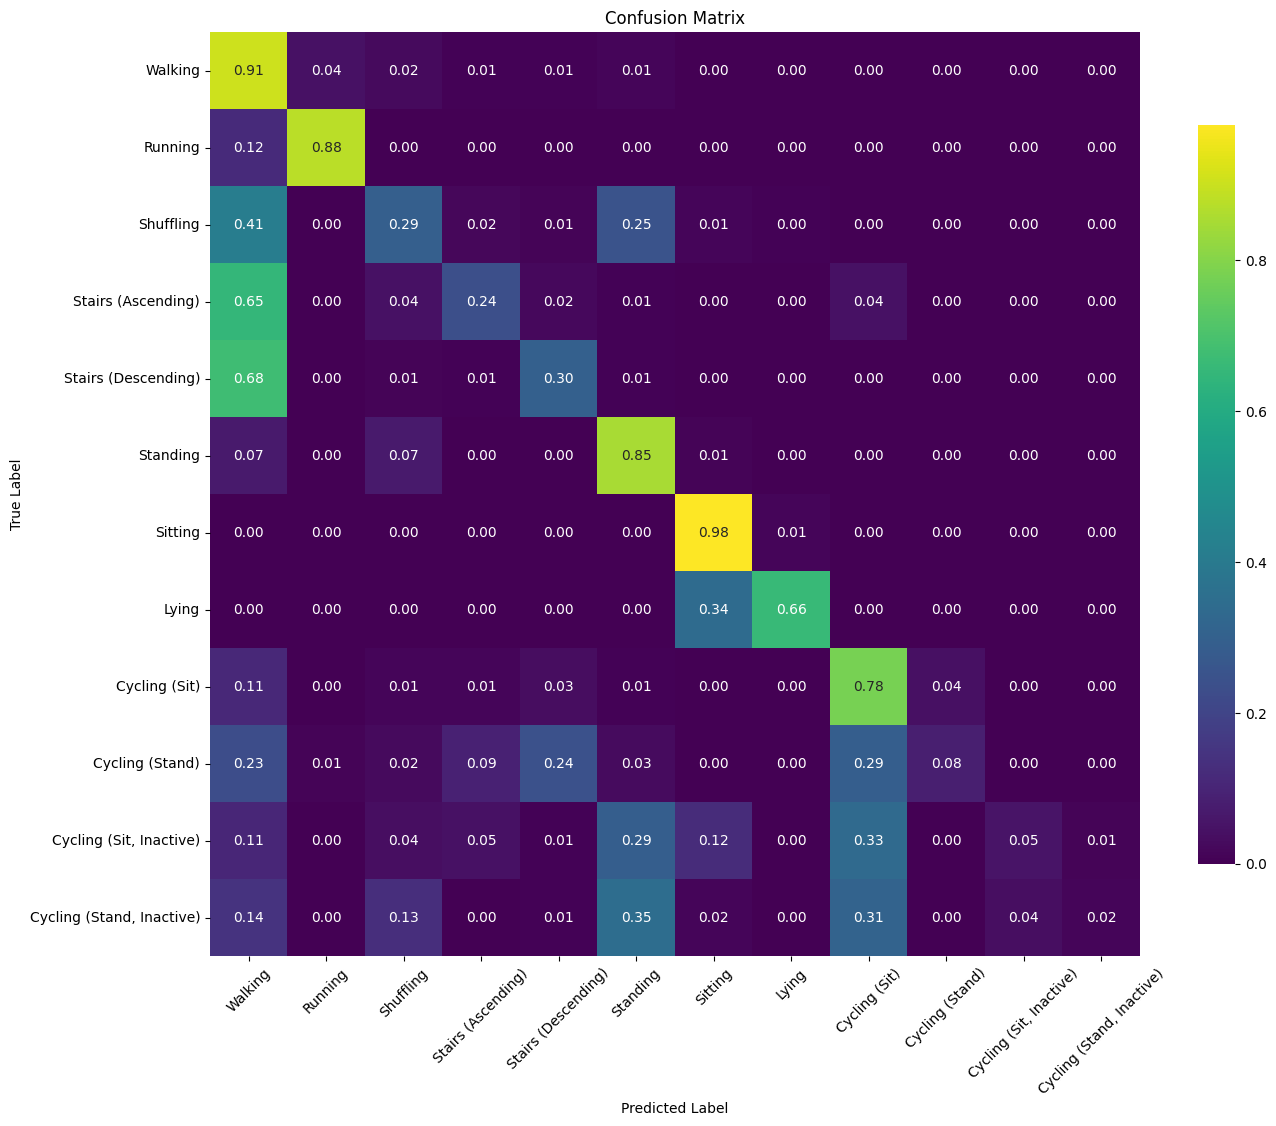

In [10]:

# Compute normalized confusion matrix
cm = confusion_matrix(y_true_original, y_pred_original, normalize='true')

# Define class labels based on continuous integer labels (0–11)
classes = list(activity_mapping.values())  # These are continuous labels mapped from 0 to 11

# Plot the heatmap with annotations
plt.figure(figsize=(15, 12))
sns.heatmap(cm, annot=True, fmt=".2f", cmap='viridis', xticklabels=classes, yticklabels=classes, cbar_kws={'shrink': 0.8})
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()

